# Exercise 4: Computing path lengths of taxi trips

This notebook uses the packages and versions described in [requirements.txt](https://github.com/jpivarski/scipy2022-loopy/blob/main/requirements.txt).

Note that "`awkward._v2`" is a preview of Awkward Array 2.0, which will be released in December 2022.

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import awkward._v2 as ak

## Chicago taxis

The City of Chicago has a [Data Portal](https://data.cityofchicago.org/) with lots of interesting datasets.

This exercise uses a dataset of [Chicago taxi trips](https://data.cityofchicago.org/Transportation/Taxi-Trips/wrvz-psew) taken from 2019 through 2021 (3 years).

Here's a map of Chicago, for reference:

<img src="https://upload.wikimedia.org/wikipedia/commons/3/3f/USA_Chicago_location_map.svg" width="500">

Taxis rarely drive into the lake (blue on the right), but they often go to the airport (yellow ball on the top-left).

The dataset that Chicago provides has trip start and stop points as longitude, latitude pairs, as well as start and end times (date-stamps), payment details, and the name of each taxi company.

For this exercise, I also added an estimated route of each taxi trip using [Open Source Routing Machine (OSRM)](http://project-osrm.org/).

The dataset has three levels of nesting:

   1. taxis
   2. trips taken by each taxi
   3. points along each trip taking by each taxi

and those levels have variable lengths: each taxi takes a different number of trips and each trip has a different number of points.

Our dataset is formatted as a 611 MB [Apache Parquet](https://parquet.apache.org/) file, provided here: [https://pivarski-princeton.s3.amazonaws.com/chicago-taxi.parquet](https://pivarski-princeton.s3.amazonaws.com/chicago-taxi.parquet).

## Reading the dataset

We can use Awkward Array's `ak.from_parquet` function to read the data.

In [2]:
taxi = ak.from_parquet(
    "https://pivarski-princeton.s3.amazonaws.com/chicago-taxi.parquet",
    row_groups=[0],
)
taxi

<Array [[{trip: {...}, ...}, ..., {...}], ...] type='353 * var * {trip: {se...'>

### Specifying row groups

We use `row_groups=[0]` to read (that is, download) only a representative part of the dataset. Row groups are contiguous rows of data in the file; the smallest granularity that can be read.

This row group has 353 entries (taxis), which is about 4% of the dataset because the file has 25 row groups.

In [3]:
ak.metadata_from_parquet(
    "https://pivarski-princeton.s3.amazonaws.com/chicago-taxi.parquet"
).metadata.num_row_groups

25

<img src="../img/columns-and-row-groups.svg" width="1200">

Despite the terms "row" and "column", the data have a complex type:

In [4]:
taxi.type.show()

353 * var * {
    trip: {
        sec: ?float32,
        km: ?float32,
        begin: {
            lon: ?float64,
            lat: ?float64,
            time: ?datetime64[ms]
        },
        end: {
            lon: ?float64,
            lat: ?float64,
            time: ?datetime64[ms]
        },
        path: var * {
            londiff: float32,
            latdiff: float32
        }
    },
    payment: {
        fare: ?float32,
        tips: ?float32,
        total: ?float32,
        type: string
    },
    company: string
}


Reading the above, this is an array of `353` elements, and each element is a variable-length lists ("`var`") of records. Each list is a taxi and each record is a taxi trip.

The "`trip`" field contains a record with

   * "`sec`": duration of taxi ride in seconds
   * "`km`": distance traveled in kilometers
   * "`begin.lon`", "`begin.lat`": beginning longitude and latitude
   * "`begin.time`": beginning time of trip
   * "`end.*`": ending longitude, latitude, and time of trip
   * "`path.londiff`", "`path.latdiff`": reconstructed path relative to "`begin.lon`", "`begin.lat`"

The "`payment`" field contains a record with

   * "`fare`": nominal taxi fare in U.S. dollars
   * "`tips`": optional tips
   * "`total`": total paid (including any taxes or other fees)
   * "`type`": method of payment

And the "`company`" field contains the name of the taxi company.

### Specifying columns

This exercise only uses a few of the columns:

   * "`trip.km`"
   * "`trip.begin.l*`"
   * "`trip.path.*`"

We can avoid reading (that is, downloading) the data we won't use by specifying `columns`.

In [5]:
taxi_columns = ak.from_parquet(
    "https://pivarski-princeton.s3.amazonaws.com/chicago-taxi.parquet",
    columns=["trip.km", "trip.begin.l*", "trip.path.*"],
    row_groups=[0],
)
taxi_columns

<Array [[{trip: {...}}, ..., {...}], ...] type='353 * var * ?{trip: {km: ?f...'>

That produces a projection of the data type—records with only the fields we want.

In [6]:
taxi_columns.type.show()

353 * var * ?{
    trip: {
        km: ?float32,
        begin: {
            lon: ?float64,
            lat: ?float64
        },
        path: var * {
            londiff: float32,
            latdiff: float32
        }
    }
}


It's possible to get the list of columns without reading the whole dataset.

In [7]:
ak.metadata_from_parquet(
    "https://pivarski-princeton.s3.amazonaws.com/chicago-taxi.parquet"
).form.columns()

['trip.sec',
 'trip.km',
 'trip.begin.lon',
 'trip.begin.lat',
 'trip.begin.time',
 'trip.end.lon',
 'trip.end.lat',
 'trip.end.time',
 'trip.path.londiff',
 'trip.path.latdiff',
 'payment.fare',
 'payment.tips',
 'payment.total',
 'payment.type',
 'company']

Between row group-selection and column-selection, you can read just the data you want for the type of analysis you'll be doing.

## Exploring the dataset

Returning to the all-column dataset, here's one taxi in detail. It took 11 trips (most of which couldn't be routed).

In [8]:
taxi[75].to_list()

[{'trip': {'sec': 0.0,
   'km': 0.0,
   'begin': {'lon': -87.66351755,
    'lat': 41.874005383,
    'time': datetime.datetime(2020, 7, 22, 13, 30)},
   'end': {'lon': -87.66351755,
    'lat': 41.874005383,
    'time': datetime.datetime(2020, 7, 22, 13, 30)},
   'path': [{'londiff': -4.500000159168849e-07,
     'latdiff': 8.617000275989994e-06},
    {'londiff': -4.500000159168849e-07, 'latdiff': 8.617000275989994e-06}]},
  'payment': {'fare': 3.25, 'tips': 0.0, 'total': 3.25, 'type': 'Cash'},
  'company': 'Taxi Affiliation Services'},
 {'trip': {'sec': 0.0,
   'km': 0.0,
   'begin': {'lon': None,
    'lat': None,
    'time': datetime.datetime(2020, 7, 22, 13, 30)},
   'end': {'lon': None,
    'lat': None,
    'time': datetime.datetime(2020, 7, 22, 13, 30)},
   'path': []},
  'payment': {'fare': 3.25, 'tips': 0.0, 'total': 3.25, 'type': 'Cash'},
  'company': 'Taxi Affiliation Services'},
 {'trip': {'sec': 60.0,
   'km': 0.0,
   'begin': {'lon': None,
    'lat': None,
    'time': datetime

The second-to-last of these has an interesting route.

In [9]:
taxi[75, -2].to_list()

{'trip': {'sec': 1500.0,
  'km': 0.0,
  'begin': {'lon': -87.66351755,
   'lat': 41.874005383,
   'time': datetime.datetime(2020, 7, 27, 15, 30)},
  'end': {'lon': -87.618677767,
   'lat': 41.835117986,
   'time': datetime.datetime(2020, 7, 27, 16, 0)},
  'path': [{'londiff': 7.550000191258732e-06,
    'latdiff': 8.617000275989994e-06},
   {'londiff': 7.550000191258732e-06, 'latdiff': 0.00012061699817422777},
   {'londiff': 0.011706549674272537, 'latdiff': 0.00031161701190285385},
   {'londiff': 0.016331549733877182, 'latdiff': 0.00028461701003834605},
   {'londiff': 0.01660054922103882, 'latdiff': -0.006792382802814245},
   {'londiff': 0.018389549106359482, 'latdiff': -0.006867383141070604},
   {'londiff': 0.018419550731778145, 'latdiff': -0.007153382990509272},
   {'londiff': 0.018912550061941147, 'latdiff': -0.010070382617413998},
   {'londiff': 0.025673549622297287, 'latdiff': -0.027933383360505104},
   {'londiff': 0.03200655058026314, 'latdiff': -0.032208383083343506},
   {'londif

Although individual rows can be presented in a JSON-like way, the dataset was made to be investigated columns at a time.

We can extract numerical data by unpacking fields.

In [10]:
taxi[75, -2].trip.path.londiff

<Array [7.55e-06, 7.55e-06, 0.0117, ..., 0.0452, 0.0453] type='16 * float32'>

In [11]:
taxi[75, -2].trip.path.latdiff

<Array [8.62e-06, 0.000121, ..., -0.0356, -0.0389] type='16 * float32'>

Let's plot it!

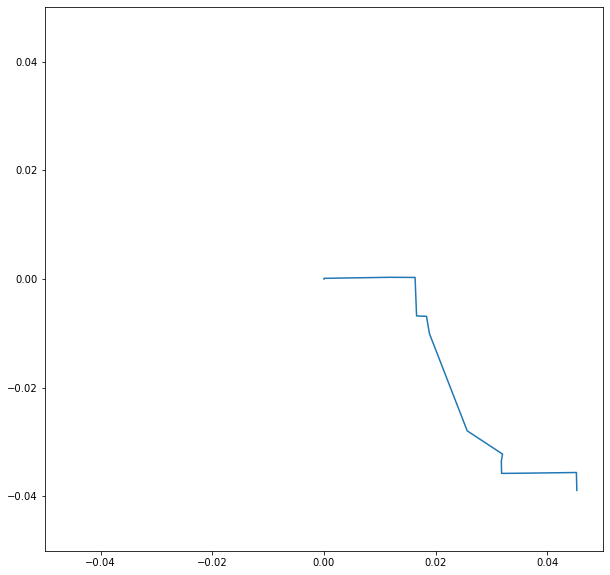

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.plot(taxi[75, -2].trip.path.londiff, taxi[75, -2].trip.path.latdiff);

ax.set_xlim(-0.05, 0.05);
ax.set_ylim(-0.05, 0.05);

Note that this path starts at `(0, 0)`. All of the paths do because these are "`londiff`" (longitude differences) and "`latdiff`" (latitude differences).

`taxi[1]` went on a lot of trips.

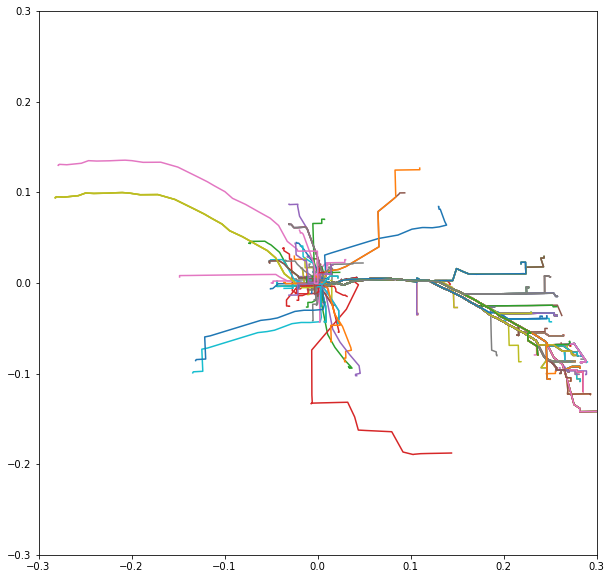

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

for x in taxi[1]:
    ax.plot(x.trip.path.londiff, x.trip.path.latdiff);

ax.set_xlim(-0.3, 0.3);
ax.set_ylim(-0.3, 0.3);

Notice that some of these appear to take the same roads, but they're offset in starting point.

We can fix this by adding the "`begin.lon`" and "`begin.lat`" to each of these paths

## Chicago taxi dataset

This exercise uses a dataset of taxi trips in Chicago from 2019 through 2021, [described here](https://data.cityofchicago.org/Transportation/Taxi-Trips/wrvz-psew) in the City of Chicago Data Portal.

In addition to the directly measured data, the route of each taxi trip was estimated by [Open Source Routing Machine (OSRM)](http://project-osrm.org/).

This gives the data a lot of structure:

   1. taxis
   2. trips taken by each taxi
   3. points along each trip taking by each taxi

The dataset, with all of that structure, is formatted as a 611 MB [Apache Parquet](https://parquet.apache.org/) file, here: [https://pivarski-princeton.s3.amazonaws.com/chicago-taxi.parquet](https://pivarski-princeton.s3.amazonaws.com/chicago-taxi.parquet).

Structure of a Parquet file:

This is the Chicago taxi dataset described in the lecture part of this workshop.

We can use a subset of the rows, so pass `row_groups=[0]` (first row group, which is 5% of the file).

The first thing we'd want to do with any file is to look at its type.

This one is an array of variable-length lists ("`var`") of records. Each list is a taxi and each record is a taxi trip.

The "`trip`" field contains a record with

   * "`sec`": duration of taxi ride in seconds
   * "`km`": distance traveled in kilometers
   * "`begin.lon`", "`begin.lat`": beginning longitude and latitude
   * "`begin.time`": beginning time of trip
   * "`end.*`": ending longitude, latitude, and time of trip
   * "`path.londiff`", "`path.latdiff`": reconstructed path relative to "`begin.lon`", "`begin.lat`"

The "`payment`" field contains a record with

   * "`fare`": nominal taxi fare in U.S. dollars
   * "`tips`": optional tips
   * "`total`": total paid (including any taxes or other fees)
   * "`type`": method of payment

And the "`company`" field contains the name of the taxi company.

In [ ]:
taxi.type.show()

This particular analysis only uses position and distance fields, so it would be faster to read only the following fields:

   * "`trip.km`": distance traveled in kilometers
   * "`trip.begin.l*`": beginning longitude and latitude, but not time
   * "`trip.path.*`": reconstructed paths

In [ ]:
taxi = ak.from_parquet(
    "https://pivarski-princeton.s3.amazonaws.com/chicago-taxi.parquet",
    row_groups=[0],
    columns=["trip.km", "trip.begin.l*", "trip.path.*"],
)
taxi.show()

This dataset only contains the fields we'll use.

In [ ]:
taxi.type.show()

## Exploring the dataset

Before jumping to the solution, let's explore the data. `taxi` is an array of lists, one list for each taxi.

Let's look at just one taxi.

In [ ]:
len(taxi[0])

In [ ]:
len(taxi[1])

We'll use `taxi[1]` because it will be easier to plot all of its trips, as there are fewer.

In [ ]:
taxi[1].show()

A lot (all?) of the `km` distances are zero, and some of the longitudes are missing.

To see more detail, unpack the "`trip`" field:

In [ ]:
taxi[1].trip.show()

And now zoom into the "`path`" field:

In [ ]:
taxi[1].trip.path.show()

The first seven paths have length 2, so look at the first long one, `taxi[1, 7]`.

In [ ]:
taxi[1, 7].trip.path.show()

Selecting `taxi[1].trip.path.londiff` or `.latdiff` gives us arrays of numbers, albeit with nested lists and missing values.

In [ ]:
(
    taxi[1].trip.path.londiff,
    taxi[1].trip.path.latdiff,
)

We can plot these values to see the shape of one taxi trip.

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(taxi[1, 7].trip.path.londiff, taxi[1, 7].trip.path.latdiff);
ax.set_xlim(-0.02, 0.02);
ax.set_ylim(-0.02, 0.02);

But it's more interesting to see all trips (by one taxi).

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

for ride in taxi[1]:
    ax.plot(ride.trip.path.londiff, ride.trip.path.latdiff);

All of these paths start at `(0, 0)` because they're actually differences with respect to `begin.lon` and `begin.lat`.

To see actual longitudes and latitudes, add the `begin.lon` and `begin.lat` to each path.

This uses broadcasting because there is one `begin.lon` value for each _list_ of `path.londiff` values.

In [ ]:
(
    taxi[1].trip.path.londiff + taxi[1].trip.begin.lon,
    taxi[1].trip.path.latdiff + taxi[1].trip.begin.lat,
)

When we plot actual longitudes and latitudes, the shape of Chicago emerges from the turn-by-turn data.

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

for ride in taxi[1]:
    if ride.trip.begin.lon is not None and ride.trip.begin.lat is not None:
        longitude = ride.trip.begin.lon + ride.trip.path.londiff
        latitude = ride.trip.begin.lat + ride.trip.path.latdiff
        ax.plot(longitude, latitude)

Below is a map of Chicago. Taxis never drive into the lake (right), but they often go to the airport (top-left).

<img src="https://upload.wikimedia.org/wikipedia/commons/3/3f/USA_Chicago_location_map.svg" width="500">

## Longitude, latitude → kilometers

Longitudes and latitudes are not uniform distances. (A degree of longitude approaches zero length at the north and south poles!)



In [ ]:
LONGITUDE, LATITUDE = -87.66178320769112, 41.896777262111726
LON_TO_KM, LAT_TO_KM = 82.98452409203695, 111.07127961503745

In [ ]:
(
    (taxi[1, 7].trip.path.londiff + taxi[1, 7].trip.begin.lon - LONGITUDE) * LON_TO_KM,
    (taxi[1, 7].trip.path.latdiff + taxi[1, 7].trip.begin.lat - LATITUDE) * LAT_TO_KM,
)

In [ ]:
km_east, km_north = (
    (taxi.trip.path.londiff + taxi.trip.begin.lon - LONGITUDE) * LON_TO_KM,
    (taxi.trip.path.latdiff + taxi.trip.begin.lat - LATITUDE) * LAT_TO_KM,
)
km_east, km_north

In [ ]:
(
    taxi.trip.path.londiff * LON_TO_KM,
    taxi.trip.path.latdiff * LAT_TO_KM,
)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

for x, y in zip(km_east[1], km_north[1]):
    if x is not None and y is not None:
        ax.plot(x, y)

In [ ]:
example_east, example_north = (
    km_east[1, 7],
    km_north[1, 7],
)
example_east, example_north

In [ ]:
fenceposts = np.array([1.1, 2.2, 3.3, 4.4, 5.5, 10, 20, 30])
fenceposts

In [ ]:
(
    fenceposts[1:],
    fenceposts[:-1],
)

In [ ]:
fenceposts[1:] - fenceposts[:-1]

In [ ]:
example_east[1:] - example_east[:-1]

<img src="../img/length-by-segment.svg" width="500">

In [ ]:
(
    (example_east[1:] - example_east[:-1])**2,
    (example_north[1:] - example_north[:-1])**2,
)

In [ ]:
np.sqrt((example_east[1:] - example_east[:-1])**2 + (example_north[1:] - example_north[:-1])**2)

<img src="../img/example-reduction-sum.svg" width="500">

In [ ]:
ak.sum(np.sqrt((example_east[1:] - example_east[:-1])**2 + (example_north[1:] - example_north[:-1])**2), axis=-1)

In [ ]:
total = 0
for i in range(len(example_east) - 1):
    Δx = example_east[i + 1] - example_east[i]
    Δy = example_north[i + 1] - example_north[i]
    Δr = np.sqrt(Δx**2 + Δy**2)
    total += Δr
total

In [ ]:
km_east.show()

In [ ]:
km_east[:, :, 1:].show()

In [ ]:
distances = ak.sum(np.sqrt((km_east[:, :, 1:] - km_east[:, :, :-1])**2 + (km_north[:, :, 1:] - km_north[:, :, :-1])**2), axis=-1)
distances.show()

In [ ]:
taxi.trip.km.show()

In [ ]:
(distances - taxi.trip.km).show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.hist2d(
    ak.flatten(ak.fill_none(distances, 0)),
    ak.flatten(ak.fill_none(taxi.trip.km, 0)),
    bins=(200, 200),
    range=((0, 50), (0, 50)),
    norm=matplotlib.colors.LogNorm(),
)
ax.plot([0, 50], [0, 50], c="orange", lw=3)

<img src="../img/as-the-crow-flies.svg" width="500">

In [ ]:
example_east

In [ ]:
example_east[-1], example_east[0]

In [ ]:
np.sqrt((example_east[-1] - example_east[0])**2 + (example_north[-1] - example_north[0])**2)

In [ ]:
contains_empty_lists = ak.Array([[1.1, 2.2, 3.3], [], [4.4, 5.5]])

try:
    contains_empty_lists[:, 0]
except Exception as err:
    print(err)

In [ ]:
ak.pad_none(contains_empty_lists, 2).show()

In [ ]:
ak.fill_none(ak.pad_none(contains_empty_lists, 2), 0).show()

In [ ]:
doesnt_contain_empty_lists = ak.fill_none(ak.pad_none(contains_empty_lists, 2), 0)

doesnt_contain_empty_lists[:, 0]

In [ ]:
pad_km_east = ak.fill_none(ak.pad_none(km_east, 2, axis=-1), 0, axis=-1)
pad_km_north = ak.fill_none(ak.pad_none(km_north, 2, axis=-1), 0, axis=-1)

In [ ]:
crow_flies = np.sqrt((pad_km_east[:, :, -1] - pad_km_east[:, :, 0])**2 + (pad_km_north[:, :, -1] - pad_km_north[:, :, 0])**2)
crow_flies.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.hist2d(
    ak.flatten(ak.fill_none(crow_flies, 0)),
    ak.flatten(ak.fill_none(taxi.trip.km, 0)),
    bins=(200, 200),
    range=((0, 50), (0, 50)),
    norm=matplotlib.colors.LogNorm(),
)
ax.plot([0, 50], [0, 50], c="orange", lw=3)